In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import models
import torch.optim as optim
from torchvision import datasets, models
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import nbconvert
import os
from glob import glob
import random
import warnings
import pickle
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from scipy import ndimage
import numpy as np
import gzip
import nibabel as nib
import cv2
from PIL import Image
import imageio
import sklearn
import shutil
import time
import os
import math
import copy
import seaborn as sns
import tarfile

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

In [2]:
# Extract covid positive images from downloaded data
tf = tarfile.open("notebook.tar.gz")
tf.extractall()

In [3]:
# Extract covid negative images from downloaded data
tf = tarfile.open("healthy_updated.tar.gz")
tf.extractall()

## 1. Format, restructure, and split COVID19 positive and negative data

In [41]:
# For covid positive set
data_dir = '/home/bhr2111/covidproject/data/'
basepath = os.path.join(data_dir,'positive/')
targetbasepath = '/home/bhr2111/covidproject/data/'
imnames = [f for f in os.listdir(basepath) if f[-3:] == "png"]
numims = len(imnames)
print("Number of images in this dataset:",numims)

# Randomize list of images to ensure randomness in train, test, valid split
randomized = random.sample(imnames,len(imnames))

# 6:2:2 train:validate:test split
train_split = .6
valid_split = .2
test_split = .2

num_train = math.ceil(train_split*numims)
num_valid = math.floor(valid_split*numims)
num_test = math.floor(test_split*numims)
print(f"Datasplit: Train: {num_train}, Validate: {num_valid}, Test: {num_test}")

for idx,image in enumerate(imnames):
    if idx <= 85: # train
        shutil.move(basepath+image, targetbasepath+'train/'+image)
    elif 86 <= idx < 114: # valid
        shutil.move(basepath+image, targetbasepath+'val/'+image)
    else: # test
        shutil.move(basepath+image, targetbasepath+'test/'+image)

Number of images in this dataset: 142
Datasplit: Train: 86, Validate: 28, Test: 28


In [6]:
# For covid negative set *COMPLETE*
data_dir = '/home/bhr2111/BMEN4460/covidproject/data/'
basepath = os.path.join(data_dir,'negative_images/')
targetbasepath = '/home/bhr2111/BMEN4460/covidproject/data/'
imnames = [f for f in os.listdir(basepath) if f[-3:] == "png"]
numims = len(imnames)
print("Number of images in this dataset:",numims)

# Randomize list of images to ensure randomness in train, test, valid split
randomized = random.sample(imnames,len(imnames))

# 6:2:2 train:validate:test split
train_split = .6
valid_split = .2
test_split = .2

num_train = math.ceil(train_split*numims)
num_valid = math.floor(valid_split*numims)
num_test = math.floor(test_split*numims)
print(f"Datasplit: Train: {num_train}, Validate: {num_valid}, Test: {num_test}")

for idx,image in enumerate(imnames):
    if idx <= 85: # train
        shutil.move(basepath+image, targetbasepath+'train/negative/'+image)
    elif 86 <= idx < 114: # valid
        shutil.move(basepath+image, targetbasepath+'val/negative/'+image)
    else: # test
        shutil.move(basepath+image, targetbasepath+'test/negative/'+image)

Number of images in this dataset: 142
Datasplit: Train: 86, Validate: 28, Test: 28


In [8]:
# I had an issue with .ipynb checkpoint directories being hidden within my data directories, only use this cell if you have this issue
testdir = '/home/bhr2111/BMEN4460/covidproject/data/val/'
[f for f in os.listdir(testdir) if f == '.ipynb_checkpoints']
#os.rmdir('/home/bhr2111/covidproject/data/val/.ipynb_checkpoints')

[]

## 2. Construct Dataset and Model 
(based off of https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch)

In [17]:
data_dir = '/home/bhr2111/BMEN4460/covidproject/data/'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

# VGG-16 Takes 224x224 images as input (resize all input images)
data_transforms = {
    TRAIN: transforms.Compose([
        # Apply data augmentations to introduce variability to network input
        transforms.RandomResizedCrop(224),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 172 images under train
Loaded 56 images under val
Loaded 56 images under test
Classes: 
['negative', 'positive']


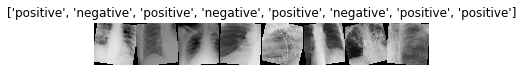

In [3]:
# Define functions to show predictions + example images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [4]:
# Visualizer for model performance during training 
# Used to output TP, TN, FP, FN data by running it on all test images
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0
    
    result_history = {'TruePositive': 0, 'TrueNegative': 0,'FalsePositive': 0,'FalseNegative': 0}
    
    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        # Document TP, TN, FN, and FP for test set
        for ii in range(0,len(labels.data.cpu())):
            real = labels.data.cpu()
            guess = predicted_labels
            if real[ii] == guess[ii] and real[ii] == 1:
                result_history['TruePositive'] += 1
            elif real[ii] == guess[ii] and real[ii] == 0:
                result_history['TrueNegative'] += 1
            elif real[ii] != guess[ii] and real[ii] == 1:
                result_history['FalseNegative'] += 1
            elif real[ii] != guess[ii] and real[ii] == 0:
                result_history['FalsePositive'] += 1
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
            
    return result_history
        
    vgg.train(mode=was_training) # Revert model back to original training state

In [5]:
# Model evaluation function, applies criterion to test set
def eval_model(vgg, criterion):
    
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True) # this isn't fully working but it is merely aesthetic

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
            
        loss_test += loss.data
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test.float() / dataset_sizes[TEST]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [18]:
vgg16 = models.vgg16_bn()
vgg16.load_state_dict(torch.load("/home/bhr2111/BMEN4460/covidproject/vgg16_bn.pth")) # Download from pytorch
# pretrained model source: https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
#print(vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers (transfer learning)
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our final layer with 2 outputs (positive and negative)
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
#print(vgg16)

In [19]:
if use_gpu:
    vgg16.cuda()
    
criterion = nn.CrossEntropyLoss() # Using cross entropy loss to evaluate predictions

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9) # momentum of 0.9 found to be best through trial and error
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) # learning rate scheduler, reduces LR as training goes on

In [20]:
# Eval model before training, expect performance around chance (50%)
print("Test before training")
eval_model(vgg16, criterion) 

Test before training
Evaluating model
----------
Test batch 0/7
Evaluation completed in 0m 19s
Avg loss (test): 0.0860
Avg acc (test): 0.5357
----------


Ground truth:


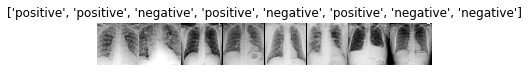

Prediction:


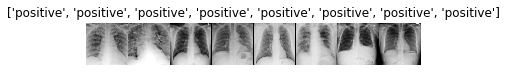

{'TruePositive': 4, 'TrueNegative': 0, 'FalsePositive': 4, 'FalseNegative': 0}

In [18]:
# Visualize model performance before training -- matches prediction of around 50% accuracy
visualize_model(vgg16)

## 3. Train Model

In [21]:
# Standard training code for the most part
def train_model(vgg, criterion, optimizer, scheduler, num_epochs,max_epochs_stop=3):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    # Implementing early stopping to prevent overfitting
    epochs_no_improve = 0
    valid_loss_min = np.Inf
    
    # Track loss and accuracy across epochs
    history = {'train_loss': list(), 'validation_loss': list(), 'train_acc': list(), 'validation_acc': list()}
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data
            acc_train += torch.sum(preds == labels.data)

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
 
        avg_loss = loss_train/ dataset_sizes[TRAIN]
        history['train_loss'].append(avg_loss)
        avg_acc = acc_train.float()/ dataset_sizes[TRAIN]
        history['train_acc'].append(avg_acc)
        
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(dataloaders[VAL]):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.data
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_sizes[VAL]
        history['validation_loss'].append(avg_loss_val)
        avg_acc_val = acc_val.float() / dataset_sizes[VAL]
        history['validation_acc'].append(avg_acc_val)
        
        print()
        print("Epoch {} result: ".format(epoch + 1)) 
        
        ## NOTE: I add +1 every time epoch or best_epoch is printed because their indexing starts at 0
        # when we want it to start at 1 for visual purposes during training printed output
        
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()

        # This section implements early stopping 
    
        # Updates valid_loss_min if this epoch's average loss is better
        if avg_loss_val < valid_loss_min:
            # Save current best model's dict
            best_model_wts = copy.deepcopy(vgg.state_dict())
            
            # Track improvement
            epochs_no_improve = 0
            valid_loss_min = avg_loss_val # update best loss with this epoch's avg loss
            valid_best_acc = avg_acc_val # update best acc with this epoch's avg acc
            best_epoch = epoch # update best epoch with this epoch id

        # Otherwise increment count of epochs with no improvement
        else:
            epochs_no_improve += 1
            # Trigger early stopping
            if epochs_no_improve >= max_epochs_stop:
                print(f'\nEarly Stopping! Total epochs: {epoch+1}. Best epoch: {best_epoch+1} with loss: {valid_loss_min:.4f} and acc: {100 * valid_best_acc:.2f}%')
                
                elapsed_time = time.time() - since
                print()
                print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

                vgg.load_state_dict(best_model_wts)
                return vgg,history # return current model and history and end training
    

    # If training not early stopped, then print best epoch info and save best model
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best loss: {:.4f} during Epoch {}".format(valid_loss_min,best_epoch+1))

    vgg.load_state_dict(best_model_wts)
    return vgg,history

In [22]:
vgg16,history = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
torch.save(vgg16.state_dict(), 'VGG16_covid19_redo_v2.pt')

Epoch 1/10
----------
Training batch 0/11.0
Validation batch 0/7
Epoch 1 result: 
Avg loss (train): 0.0868
Avg acc (train): 0.5930
Avg loss (val): 0.1305
Avg acc (val): 0.5000
----------

Epoch 2/10
----------
Training batch 0/11.0
Validation batch 0/7
Epoch 2 result: 
Avg loss (train): 0.0677
Avg acc (train): 0.7326
Avg loss (val): 0.0571
Avg acc (val): 0.7679
----------

Epoch 3/10
----------
Training batch 0/11.0
Validation batch 0/7
Epoch 3 result: 
Avg loss (train): 0.0600
Avg acc (train): 0.7674
Avg loss (val): 0.0436
Avg acc (val): 0.8571
----------

Epoch 4/10
----------
Training batch 0/11.0
Validation batch 0/7
Epoch 4 result: 
Avg loss (train): 0.0509
Avg acc (train): 0.8314
Avg loss (val): 0.0542
Avg acc (val): 0.8214
----------

Epoch 5/10
----------
Training batch 0/11.0
Validation batch 0/7
Epoch 5 result: 
Avg loss (train): 0.0466
Avg acc (train): 0.8663
Avg loss (val): 0.0350
Avg acc (val): 0.8750
----------

Epoch 6/10
----------
Training batch 0/11.0
Validation batch

In [23]:
eval_model(vgg16, criterion)

Evaluating model
----------
Test batch 0/7
Evaluation completed in 0m 19s
Avg loss (test): 0.0130
Avg acc (test): 0.9464
----------


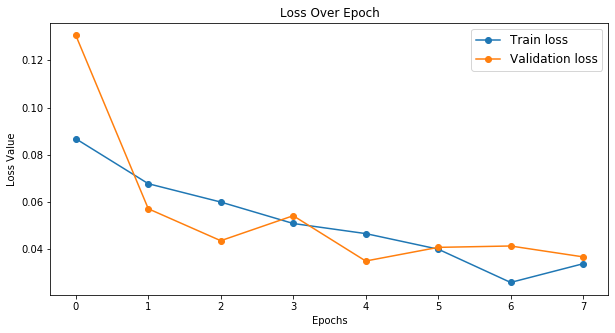

In [25]:
plt.figure(figsize=(10,5))
plt.title('Loss Over Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
train_curve = plt.plot(history['train_loss'], marker = 'o', label = 'Train loss')
validation_curve = plt.plot(history['validation_loss'], marker = 'o', label = 'Validation loss')
plt.legend(fontsize = 12)
#plt.show()
plt.savefig('Loss Over Epoch')

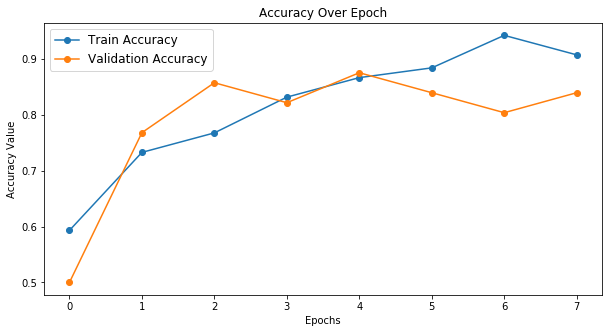

In [28]:
plt.figure(figsize=(10,5))
plt.title('Accuracy Over Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Value')
train_curve = plt.plot(history['train_acc'], marker = 'o', label = 'Train Accuracy')
validation_curve = plt.plot(history['validation_acc'], marker = 'o', label = 'Validation Accuracy')
plt.legend(fontsize = 12)
#plt.show()
plt.savefig('Accuracy Over Epoch')

In [9]:
!tar chvfz data.tar.gz '/home/bhr2111/BMEN4460/covidproject/data'

tar: Removing leading `/' from member names
/home/bhr2111/BMEN4460/covidproject/data/
/home/bhr2111/BMEN4460/covidproject/data/train/
/home/bhr2111/BMEN4460/covidproject/data/train/positive/
/home/bhr2111/BMEN4460/covidproject/data/train/positive/294.png
/home/bhr2111/BMEN4460/covidproject/data/train/positive/54.png
/home/bhr2111/BMEN4460/covidproject/data/train/positive/321.png
/home/bhr2111/BMEN4460/covidproject/data/train/positive/90.png
/home/bhr2111/BMEN4460/covidproject/data/train/positive/94.png
/home/bhr2111/BMEN4460/covidproject/data/train/positive/315.png
/home/bhr2111/BMEN4460/covidproject/data/train/positive/214.png
/home/bhr2111/BMEN4460/covidproject/data/train/positive/211.png
/home/bhr2111/BMEN4460/covidproject/data/train/positive/320.png
/home/bhr2111/BMEN4460/covidproject/data/train/positive/29.png
/home/bhr2111/BMEN4460/covidproject/data/train/positive/283.png
/home/bhr2111/BMEN4460/covidproject/data/train/positive/111.png
/home/bhr2111/BMEN4460/covidproject/data/trai

In [9]:
# Reload best model for further analysis of performance
print("Loading pretrained model..")
vgg16.load_state_dict(torch.load('/home/bhr2111/BMEN4460/covidproject/VGG16_covid19_redo_v1.pt'))
print("Loaded!")

Loading pretrained model..
Loaded!


In [11]:
eval_model(vgg16, criterion)

Evaluating model
----------
Test batch 0/7
Evaluation completed in 0m 19s
Avg loss (test): 0.0120
Avg acc (test): 0.9643
----------


Ground truth:


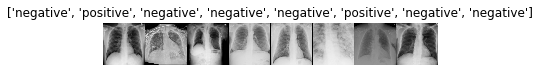

Prediction:


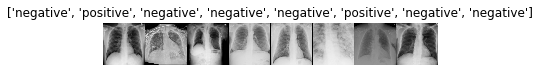

Ground truth:


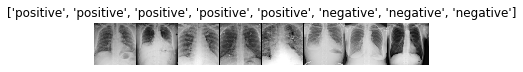

Prediction:


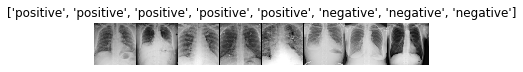

Ground truth:


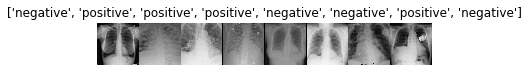

Prediction:


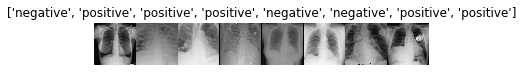

Ground truth:


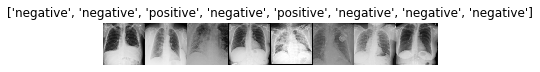

Prediction:


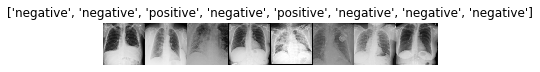

Ground truth:


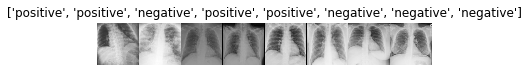

Prediction:


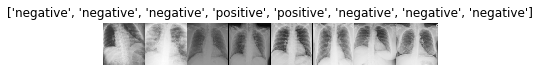

Ground truth:


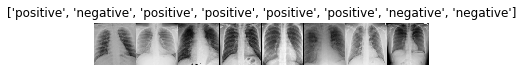

Prediction:


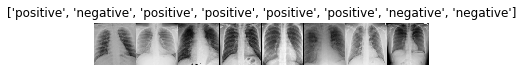

Ground truth:


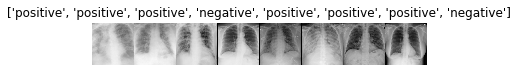

Prediction:


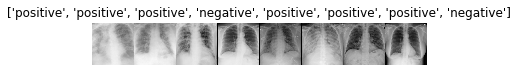

In [29]:
res = visualize_model(vgg16, num_images=100) # This outputs the true positive, true negative etc. data dict for test set

In [30]:
res_array = np.array([[res['TrueNegative'],res['FalsePositive']],[res['FalseNegative'],res['TruePositive']]])

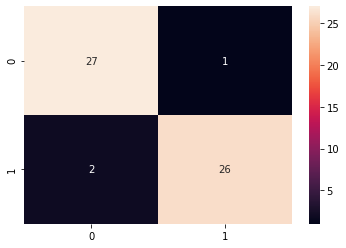

In [31]:
sns.heatmap(res_array, annot=True)
plt.show()

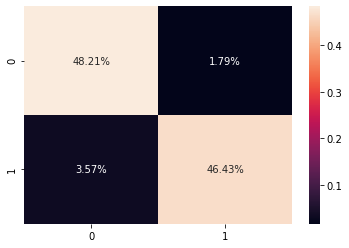

In [32]:
sns.heatmap(res_array/np.sum(res_array), annot=True, 
            fmt='.2%')
plt.show()

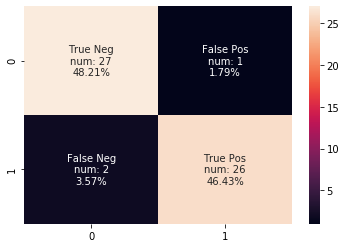

In [34]:
# Final confusion matrix using seaborn
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["num: {0:0.0f}".format(value) for value in
                res_array.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     res_array.flatten()/np.sum(res_array)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(res_array, annot=labels, fmt='')#, cmap='Blues')
#plt.show()
plt.savefig('New Confusion Matrix')